# Job Shop Scheduling Problem

The job shop scheduling problem is a fundamental problem in planning.

We assume we have a set of machines and a set of jobs.  Each job must be processesed on each of the machines for a given processing time, but each machine can only process one job at a time.

Each job has an ordering of the machines on which it needs to be processed.  

The goal is to minimize the time it takes to complete all of the jobs.  

This is called Makespan Minimization.


In [44]:
from gurobipy import Model, GRB
import matplotlib.pyplot as plt


# Input data
n = 4 # number of jobs
m = 3 # number of machines
times = [[4,2,1], [3,1,2], [2,4,2],[2,3,2]] # processing times of jobs on machines

# Calculate a large constant 'M' that will be used in the model. This is the summation of all processing times.
M = sum(times[i][j] for i in range(n) for j in range(m))
machines = [[0, 1, 2], [2, 1, 0], [0, 2, 1],[1,0,2]] # ordering of jobs on machines

# # Input data
# n = 1 # number of jobs
# m = 3 # number of machines
# times = [[2,4,2]] # processing times of jobs on machines

# # Calculate a large constant 'M' that will be used in the model. This is the summation of all processing times.
# M = sum(times[i][j] for i in range(n) for j in range(m))
# machines = [ [0, 2, 1]] # ordering of jobs on machines

In [48]:
# Initialize the optimization model
model = Model("jssp")

# Create variables
x = {}  # Starting times for jobs on machines
y = {}  # Binary variables to help model non-overlapping constraints

# Define decision variables
for i in range(m):
    for j in range(n):
        # Continuous variable representing the starting time of job 'j' on machine 'i'
        x[i, j] = model.addVar(vtype=GRB.CONTINUOUS, name=f"x_{i}_{j}")
        
        for k in range(n):
            if j != k:
                # Binary variable that is 1 if job 'j' precedes job 'k' on machine 'i', and 0 otherwise
                y[i, j, k] = model.addVar(vtype=GRB.BINARY, name=f"y_{i}_{j}_{k}")

# Variable representing the makespan (maximum completion time across all jobs)
C = model.addVar(vtype=GRB.CONTINUOUS, name="C")

# Objective function: Minimize the makespan (adapted to also start jobs as soon as possible)
model.setObjective(C + 0.0001*sum(x[i, j] for i in range(m) for j in range(n)), GRB.MINIMIZE)

#model.addConstr(x[2,2]==2)
# Add constraints
for j in range(n):
    for r in range(1, m):
        # Precedence constraints: Ensure that a job on a machine only starts after 
        # the processing of the previous machine is concluded
        model.addConstr(x[machines[j][r], j] >= x[machines[j][r-1], j] + times[j][machines[j][r-1]])

        
# for j in range(n):
#     for r in range(m):    
#         # Ensure the makespan (C) is at least the completion time of every job
#         model.addConstr(C >= x[r, j] + times[j][r])

        
for j in range(n):
    #for r in range(m):    
        # Ensure the makespan (C) is at least the completion time of every job
    machine = machines[j][m-1]
    model.addConstr(C >= x[machine, j] + times[j][machine])
        
for i in range(m):
    for j in range(n):
        for k in range(n):
            if j != k:
                # Disjunctive constraints: Ensure that two jobs do not overlap on the same machine.
                # These constraints use the big 'M' methodology in combination with binary variables.
                model.addConstr(x[i, j] >= x[i, k] + times[k][i] - M * (1 - y[i, j, k]))
                model.addConstr(x[i, k] >= x[i, j] + times[j][i] - M * y[i, j, k])

# Optimize the model to find the optimal solution
model.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 84 rows, 49 columns and 240 nonzeros
Model fingerprint: 0x63d89c04
Variable types: 13 continuous, 36 integer (36 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e-04, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+01]
Found heuristic solution: objective 12.0053000
Presolve removed 16 rows and 16 columns
Presolve time: 0.00s
Presolved: 68 rows, 33 columns, 176 nonzeros
Variable types: 13 continuous, 20 integer (20 binary)

Root relaxation: objective 8.003000e+00, 15 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    8.00300    0   12   12.00530    8.00300 

In [49]:
# Print Solution
print("\nSolution:\n")
for i in range(m):
    # Sort jobs for each machine based on start times
    scheduled_jobs = sorted([(int(x[i, j].X), j) for j in range(n)])
    
    print(f"Machine {i}:")
    for start_time, job in scheduled_jobs:
        print(f"  Job {job} from time {start_time} to {start_time + times[job][i]}")
    print()


Solution:

Machine 0:
  Job 2 from time 0 to 2
  Job 0 from time 1 to 5
  Job 3 from time 5 to 7
  Job 1 from time 7 to 10

Machine 1:
  Job 3 from time 0 to 3
  Job 1 from time 2 to 3
  Job 2 from time 4 to 8
  Job 0 from time 7 to 9

Machine 2:
  Job 1 from time 0 to 2
  Job 2 from time 2 to 4
  Job 3 from time 7 to 9
  Job 0 from time 9 to 10



# Gantt Chart
Although the data above is useful, it is convenient to display the solution in a Gantt chart.

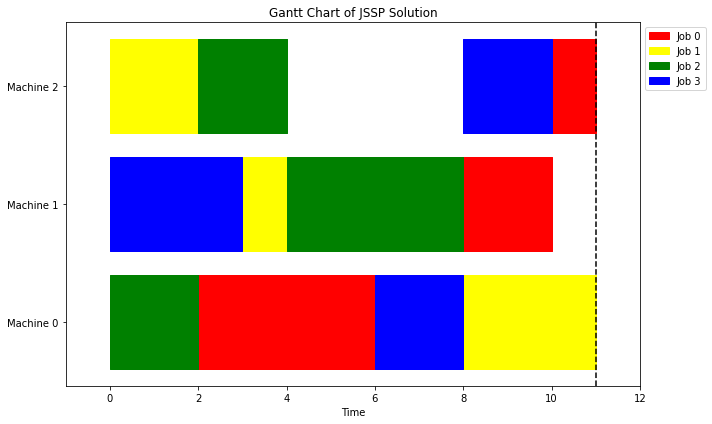

In [50]:
# Check if the optimization was successful
if model.Status == GRB.OPTIMAL:
    # Visualize the optimal schedule using a Gantt chart
    if n <= 4:
        job_colors = ['red','yellow','green', 'blue']
    else:
        import matplotlib.cm as cm
        job_colors = [cm.viridis(i/n) for i in range(n)]
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    ax.set_xlim(-1,C.x+1)
    for j in range(n):
        for r in range(m):
            machine = r
            # Plot each job's duration on its respective machine
            ax.broken_barh([(model.getVarByName(f"x_{machine}_{j}").x, times[j][r])], (machine - 0.4, 0.8), color=job_colors[j], label=f"Job {j}")

    ax.set_yticks(list(range(m)))
    ax.set_yticklabels([f"Machine {i}" for i in range(m)])
    ax.set_xlabel("Time")
    ax.set_title("Gantt Chart of JSSP Solution")
    
    # Add a vertical line at max time
    ax.axvline(x=C.x, color='black', linestyle='--', label='C_max')
    
    # Add a legend to the chart for clarity
    handles = [plt.Rectangle((0,0),1,1, color=job_colors[j]) for j in range(n)]
    
    ax.legend(handles, [f"Job {j}" for j in range(n)], loc="upper left", bbox_to_anchor=(1, 1))
    


    plt.tight_layout()
    plt.show()
else:
    print("No optimal solution found!")


# Heuristic Solution testing
We begin by developing a function that can evaluate solution to the JSSP.  As it turns out, the only information need to determine a solution to the JSSP is order in which jobs are processed on  machines.  

In [4]:
def jssp(orders, times, machines):
    # Initialize machine times and results
    machine_times = {machine: 0 for machine in orders.keys()}
    job_end_times = {job: 0 for job in range(len(times))}
    x = {}
    
    # Determine x values
    for machine, job_sequence in orders.items():
        for job in job_sequence:
            # Identify the index of the current machine in the job's machine order
            machine_idx = machines[job].index(machine)
            # Check if it's the first machine for the job, else get the end time of the previous machine
            prev_machine_end_time = 0
            if machine_idx != 0:
                prev_machine = machines[job][machine_idx-1]
                prev_machine_end_time = x.get((prev_machine, job), 0) + times[job][prev_machine]
            # Determine start time
            start_time = max(machine_times[machine], prev_machine_end_time)
            end_time = start_time + times[job][machine]
            x[machine, job] = start_time
            # Update machine time and job end time
            machine_times[machine] = end_time
            job_end_times[job] = end_time

    # Calculate makespan
    makespan = max(job_end_times.values())

    # Determine y values
    y = {}
    for machine in orders:
        for idx_j, j in enumerate(orders[machine]):
            for idx_k, k in enumerate(orders[machine]):
                if idx_j != idx_k:
                    if x[machine, j] < x[machine, k]:
                        y[machine, j, k] = 1
                    else:
                        y[machine, j, k] = 0
                        
    return x, y, makespan

# Sample usage:
orders = {
    0: [0, 1, 2],
    1: [1, 0, 2],
    2: [0, 2, 1]
}
times = [[4,2,1], [3,1,2], [2,4,2]]
machines = [[0, 1, 2], [2, 1, 0], [0, 2, 1]]



orders = {
    0: [2,0,3,1],
    1: [3,1,2,0],
    2: [1,2,3,0]
}
times = [[4,2,1], [3,1,2], [2,4,2],[2,3,2]] # processing times of jobs on machines

# Calculate a large constant 'M' that will be used in the model. This is the summation of all processing times.
machines = [[0, 1, 2], [2, 1, 0], [0, 2, 1],[1,0,2]] # ordering of jobs on machines


x_result, y_result, obj_value = jssp(orders, times, machines)
print("x values:", x_result)
print("y values:", y_result)
print("Objective value:", obj_value)


x values: {(0, 2): 0, (0, 0): 2, (0, 3): 6, (0, 1): 8, (1, 3): 0, (1, 1): 3, (1, 2): 4, (1, 0): 8, (2, 1): 0, (2, 2): 2, (2, 3): 8, (2, 0): 10}
y values: {(0, 2, 0): 1, (0, 2, 3): 1, (0, 2, 1): 1, (0, 0, 2): 0, (0, 0, 3): 1, (0, 0, 1): 1, (0, 3, 2): 0, (0, 3, 0): 0, (0, 3, 1): 1, (0, 1, 2): 0, (0, 1, 0): 0, (0, 1, 3): 0, (1, 3, 1): 1, (1, 3, 2): 1, (1, 3, 0): 1, (1, 1, 3): 0, (1, 1, 2): 1, (1, 1, 0): 1, (1, 2, 3): 0, (1, 2, 1): 0, (1, 2, 0): 1, (1, 0, 3): 0, (1, 0, 1): 0, (1, 0, 2): 0, (2, 1, 2): 1, (2, 1, 3): 1, (2, 1, 0): 1, (2, 2, 1): 0, (2, 2, 3): 1, (2, 2, 0): 1, (2, 3, 1): 0, (2, 3, 2): 0, (2, 3, 0): 1, (2, 0, 1): 0, (2, 0, 2): 0, (2, 0, 3): 0}
Objective value: 11


In [10]:
import matplotlib.pyplot as plt
def visualize_schedule(x, times, n, m, obj_value):
    # Visualize the schedule using a Gantt chart
    if n <= 4:
        job_colors = ['red','yellow','green', 'blue']
    else:
        import matplotlib.cm as cm
        job_colors = [cm.viridis(i/n) for i in range(n)]
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    ax.set_xlim(-1, obj_value + 1)
    for j in range(n):
        for r in range(m):
            machine = r
            # Plot each job's duration on its respective machine
            ax.broken_barh([(x[machine, j], times[j][machine])], (machine - 0.4, 0.8), color=job_colors[j], label=f"Job {j}")

    ax.set_yticks(list(range(m)))
    ax.set_yticklabels([f"Machine {i}" for i in range(m)])
    ax.set_xlabel("Time")
    ax.set_title("Gantt Chart of JSSP Solution")
    
    # Add a vertical line at max time
    ax.axvline(x=obj_value, color='black', linestyle='--', label='C_max')
    
    # Add a legend to the chart for clarity
    handles = [plt.Rectangle((0,0),1,1, color=job_colors[j]) for j in range(n)]
    
    ax.legend(handles, [f"Job {j}" for j in range(n)], loc="upper left", bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.show()




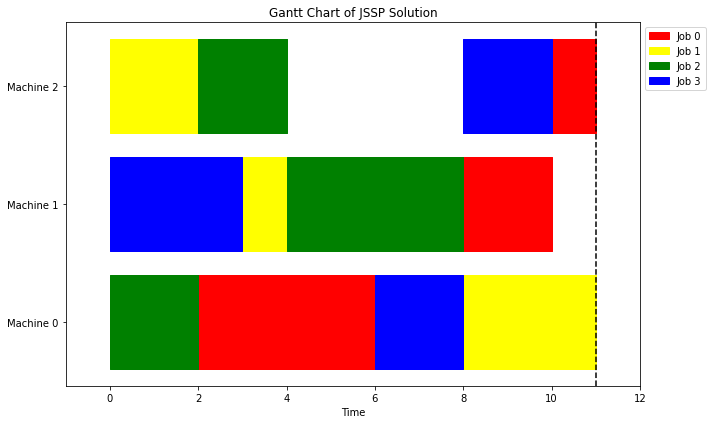

In [11]:
# Sample usage:
orders = {
    0: [2,0,3,1],
    1: [3,1,2,0],
    2: [1,2,3,0]
}
times = [[4,2,1], [3,1,2], [2,4,2],[2,3,2]] # processing times of jobs on machines

# Calculate a large constant 'M' that will be used in the model. This is the summation of all processing times.
machines = [[0, 1, 2], [2, 1, 0], [0, 2, 1],[1,0,2]] # ordering of jobs on machines

x_result, _, obj_value = jssp(orders, times, machines)
visualize_schedule(x_result, times, len(times), len(orders), obj_value)

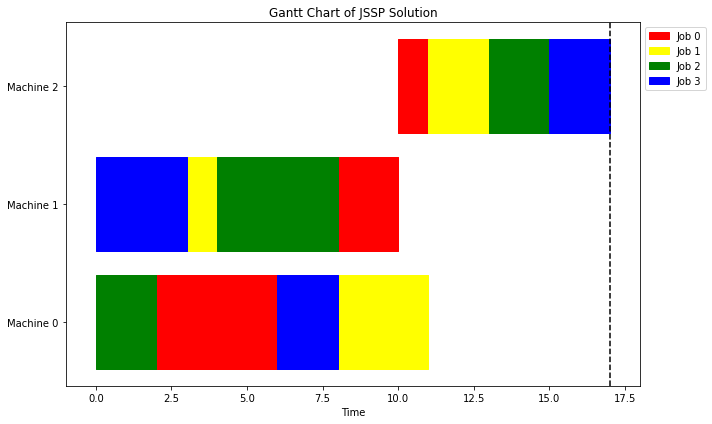

In [12]:
# Sample usage:
orders = {
    0: [2,0,3,1],
    1: [3,1,2,0],
    2: [0,1,2,3]
}
times = [[4,2,1], [3,1,2], [2,4,2],[2,3,2]] # processing times of jobs on machines

# Calculate a large constant 'M' that will be used in the model. This is the summation of all processing times.
machines = [[0, 1, 2], [2, 1, 0], [0, 2, 1],[1,0,2]] # ordering of jobs on machines

x_result, _, obj_value = jssp(orders, times, machines)
visualize_schedule(x_result, times, len(times), len(orders), obj_value)